In [1]:
from numpy.random import normal
import numpy as np
from numpy.linalg import inv
from sympy import symbols, diff
import matplotlib.pyplot as plt

import numdifftools as nd
def partial_function(f___,input,pos,value):
    tmp  = input[pos]
    input[pos] = value
    ret = f___(*input)
    input[pos] = tmp
    return ret
def partial_derivative(f,input):
    ret = np.empty(len(input))
    for i in range(len(input)):
        fg = lambda x:partial_function(f,input,i,x)
        ret[i] = nd.Derivative(fg)(input[i])
    return ret

## Initialize parameters

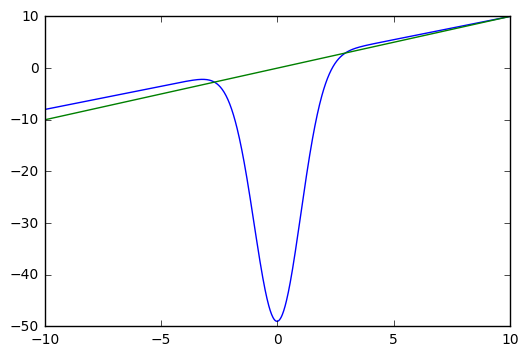

In [127]:
#Create the model

T = 1000
np.random.seed(0)


# function 1 : Gabor filter
Q = np.identity(1) * 0.2
R = np.identity(1) * 0.2
f = lambda k,x_k: 0.01*x_k+20*np.sin(x_k)*np.exp(-x_k**2/2)

# function 2 : Well
Q = np.identity(1) * 1
R = np.identity(1) * 1
f = lambda k,x_k: 0.9*x_k-50*np.exp(-x_k**2/2)+1

# # function 3 : Sigmoid
# Q = np.identity(1) * 1
# R = np.identity(1) * 1
# f = lambda k,x_k:7*(1/(1+np.exp(-x_k))-0.5)

absc = np.linspace(-10,10,1000)
ordo = f(1,absc)

plt.figure()
plt.plot(absc,ordo)
plt.plot(absc,absc)
plt.show()


h = lambda k,x_k: (1 + 1/(k+1))*x_k

B = np.zeros([1,1])
D = np.zeros([1,1])

mean = np.zeros([1,1])

x = np.zeros((T,1))
y = np.zeros((T,1))
u = np.zeros((T,1))


## Extended kernel function for one iteration

In [113]:
def extended_KF(x0,y,T,f,h,R,Q):

    #Initialization
    V = np.zeros([T,1])
    V[0] = np.identity(1)
    x_f = np.zeros([T,1])
    x_f[0] = x0
    
    V_plus_all = np.zeros([T,1])
    A_all = np.zeros([T,1])
    C_all = np.zeros([T,1])
    x_plus_all = np.zeros([T,1])

    #Propagation
    for k in range(1,T):   
        A_all[k-1] = np.matrix(partial_derivative(f,np.array([k-1,x_f[k-1]]))[1]) #derivative of f, with respect to x_k
        x_plus = f(k-1,x_f[k-1])
        x_plus_all[k] = x_plus
        C_all[k] = np.matrix(partial_derivative(h,np.array([k,x_plus]))[1]) #derivative of h, with respect to x_k
        V_plus = np.matrix(A_all[k-1].dot(V[k-1])).dot(A_all[k-1].T) + Q 
        V_plus_all[k] = V_plus

        K = V_plus.dot(C_all[k].T).dot(inv(C_all[k].dot(V_plus.dot(C_all[k].T) + R)))
        x_f[k] = x_plus + K.dot(y[k] - h(k,x_plus))
        V[k] = (np.identity(K.shape[0]) - K.dot(C_all[k])).dot(V_plus)

    A_all[T-1] = np.matrix(partial_derivative(f,np.array([T-1,x_f[T-1]]))[1]) #derivative of f, with respect to x_k

    #Recursive
    #F = A, B = H, P = V

    #Initialization
    x_b = np.zeros([T,1])
    x_b[T-1] = x_f[-1]
    V_b = np.zeros([T,1])
    V_b[-1] = V[-1]

    #Propagation
    #Remark: compared to the table 1.2 on page 17, we changed all the indexes by -1
    for k in range(T-1, 0, -1): #from T-1 to 1 by -1 increments

        A_b = np.matrix(V[k-1].dot(A_all[k].T)).dot(inv(np.matrix(V_plus_all[k])))
        V_b[k-1] = V[k-1] - A_b.dot(V_plus_all[k] - V_b[k]).dot(A_b.T)
        x_b[k-1] = x_f[k-1] + A_b.dot(x_b[k] - x_plus_all[k])
    
    return x_f,x_b

## Launch EKF


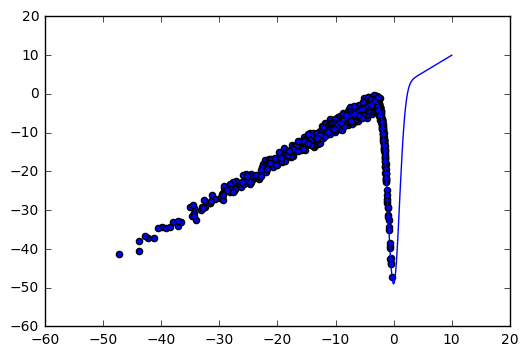

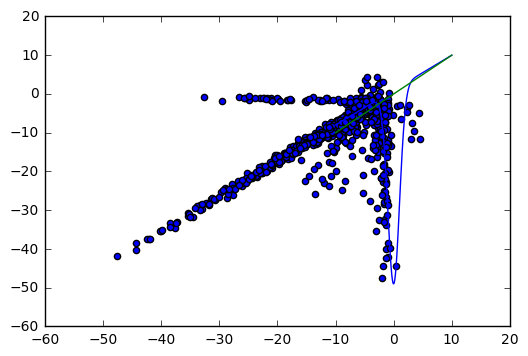

In [129]:
iterations = 1

x_it = np.zeros((iterations,T))
y_it = np.zeros((iterations,T))
x_f_it = np.zeros((iterations,T))
x_b_it = np.zeros((iterations,T))

for i in range(iterations):    
    x[0] = normal(0,10)

    #Propagation
    for k in range(T-1):
        x[k+1] = f(k,x[k]) + np.dot(B,u[k]) + normal(mean,Q)
    for k in range(T):
        y[k] = h(k,x[k])  + np.dot(D,u[k]) + normal(mean,R)
        
    x_it[i] = x.flatten()
    y_it[i] = y.flatten()
    
    x_f,x_b = extended_KF(x[0],y,T,f,h,R,Q)
    
    x_f_it[i] = x_f.flatten()
    x_b_it[i] = x_b.flatten()
    
absc = np.linspace(-10,10,1000)
ordo = f(1,absc)

plt.figure()
plt.plot(absc,ordo)
for i in range(iterations):
    plt.scatter(x_it[i,:-1],x_it[i,1:])
# plt.xlim(-10,10)
plt.savefig("x3.eps",format = "eps")
    
# plt.figure()
# plt.plot(absc,ordo)
# for i in range(iterations):
#     plt.scatter(x_f_it[i,:-1],x_f_it[i,1:])
# plt.xlim(-10,10)

plt.figure()
plt.plot(absc,ordo)
plt.plot(absc,absc)
for i in range(iterations):
    plt.scatter(x_b_it[i,:-1],x_b_it[i,1:])
plt.savefig("x3_b.eps",format = "eps")
# plt.xlim(-10,10)
# plt.ylim(-15,15)

plt.show()

## Plot y


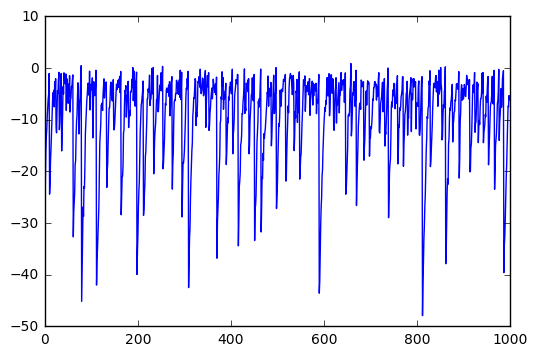

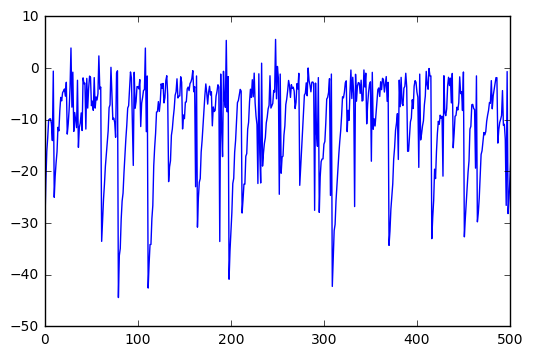

In [132]:
plt.figure()
plt.plot(y_it[0])
# plt.ylim(-10,10)
plt.show()

y_b = np.zeros((T,1))
for k in range(T):
    y_b[k] = h(k,x_b_it[0,k])  + np.dot(D,u[k]) + normal(mean,R)
plt.plot(y_b)
# plt.ylim(-10,10)
plt.xlim(0,500)
plt.show()
